In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
from keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#For ignoring warning
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

In [2]:
data = pd.read_csv("dataset.csv")

In [3]:
# remove "(<.*?>)" markup
data['text'] = data['text'].apply(lambda x: re.sub('(<.*?>)', ' ', x))

# remove punctuation marks 
data['text'] = data['text'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
    
# remove whitespace
data['text'] = data['text'].apply(lambda x: x.strip())

# remove all strings that contain a non-letter
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
    
# convert to lower
data['text'] = data['text'].apply(lambda x: x.lower())

In [4]:
words = data['text'].apply(lambda x: text_to_word_sequence(x))

In [5]:
stop_words = set(stopwords.words('english'))
filtered_words = words.apply(lambda x: [w for w in x if w not in stop_words])
data['text'] = filtered_words.apply(lambda x: " ".join(x))

In [6]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
  
data['text']=data['text'].apply(lambda x: lemmatizer.lemmatize(x))

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

lower_count_thr = 100 # rare words/tokens
upper_count_thr = 5000 # frequent/common tokens

tv=TfidfVectorizer(min_df=lower_count_thr,max_df=upper_count_thr,binary=False,ngram_range=(1,1))

In [8]:
#transformed train texts
x =tv.fit_transform(data.text)
y = data.classes.values

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.2,shuffle=True)

## SVM

In [50]:
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

SVC(gamma='auto', kernel='linear')

In [51]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  81.7734375


In [54]:
import joblib
joblib.dump(SVM, "svm.pkl")

['svm.pkl']

In [10]:
import joblib
from sklearn import svm
SVM = joblib.load("svm.pkl")
predictions_SVM = SVM.predict(X_test)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6528
           1       0.81      0.82      0.82      6272

    accuracy                           0.82     12800
   macro avg       0.82      0.82      0.82     12800
weighted avg       0.82      0.82      0.82     12800



## K-nearest

In [42]:
from sklearn.neighbors import KNeighborsClassifier

accuracy_list = []

for i in range(50):
    knn = KNeighborsClassifier(n_neighbors = (i + 1))
    knn.fit(X_train, y_train)

    accuracy_list.append(knn.score(X_test, y_test))

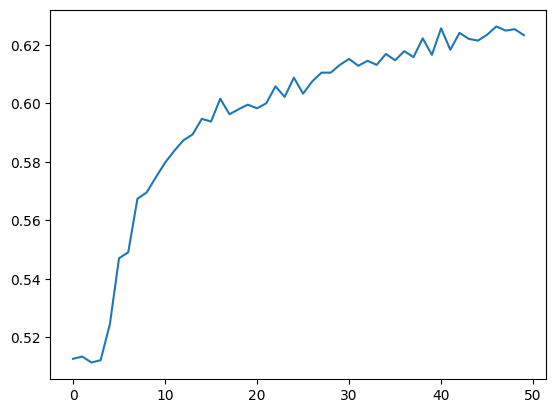

In [43]:
import matplotlib.pyplot as plt

plt.plot(accuracy_list)

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Define k fold cross validation (k = 10)
kFold=KFold(n_splits=10,random_state=42,shuffle=True)

scores=[]
knn_2 = KNeighborsClassifier(n_neighbors = 40)
for train_index,test_index in kFold.split(x):
    
    # select the chosen instances in X and y
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

    # fit the knn model with selected data
    knn_2.fit(X_train, y_train)
    # add the score to the list of scores for each fold
    scores.append(knn_2.score(X_test, y_test))

# fit the knn model with ordinary choice of train and test set
knn_2.fit(X_train,y_train)
scores.append(knn_2.score(X_test,y_test))
print(scores)

[0.60625, 0.600625, 0.60296875, 0.6075, 0.609375, 0.60328125, 0.606875, 0.623125, 0.603125, 0.6165625, 0.6165625]


In [46]:
average_score = sum(scores) / len(scores)
print(average_score)

0.6087499999999999


## logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression

# Define k fold cross validation (k = 10)
kFold=KFold(n_splits=10,random_state=42,shuffle=True)

scores=[]
clg = LogisticRegression()
for train_index,test_index in kFold.split(x):
    
    # select the chosen instances in X and y
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

    # fit the knn model with selected data
    clg.fit(X_train, y_train)
    # add the score to the list of scores for each fold
    scores.append(clg.score(X_test, y_test))

# fit the knn model with ordinary choice of train and test set
clg.fit(X_train,y_train)
scores.append(clg.score(X_test,y_test))
print(scores)


[0.82703125, 0.82546875, 0.83640625, 0.8265625, 0.82140625, 0.83078125, 0.8134375, 0.8303125, 0.82859375, 0.82015625, 0.82015625]


In [48]:
accuracy_score_clg = sum(scores) / len(scores)
print(accuracy_score_clg)

0.8254829545454545


## Neural Network

In [10]:
from sklearn import preprocessing
from keras.utils import to_categorical

le = preprocessing.LabelEncoder()

In [15]:
from keras.models import  Sequential
from keras.layers import Dense, Dropout, Embedding, Activation
from sklearn.model_selection import KFold

def build_model(model):
    model.add(Dense(256, input_dim=12220, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dropout(0.2))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define k fold cross validation (k = 10)
kFold=KFold(n_splits=10,random_state=42,shuffle=True)

scores=[]
for train_index,test_index in kFold.split(x):

    model = Sequential()
    build_model(model)
    
    # select the chosen instances in X and y
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

    X_train.sort_indices()
    X_test.sort_indices()

    y_train_nn = le.fit_transform(y_train)
    y_test_nn = le.fit_transform(y_test)
    y_train_nn = to_categorical(y_train_nn)
    y_test_nn = to_categorical(y_test_nn)

    # fit the knn model with selected data
    model.fit(X_train, y_train_nn, epochs = 3, batch_size = 16, validation_data = (X_test, y_test_nn))
    y_predict = model.predict(X_test)
    predicted_categories = np.argmax(y_predict, axis=1)
    # add the score to the list of scores for each fold
    scores.append(accuracy_score(y_test, predicted_categories))

print(scores)

Epoch 1/3
3600/3600 [==============================] - 85s 23ms/step - loss: 0.4573 - accuracy: 0.7829 - val_loss: 0.3933 - val_accuracy: 0.8303
Epoch 2/3
3600/3600 [==============================] - 83s 23ms/step - loss: 0.2857 - accuracy: 0.8837 - val_loss: 0.3665 - val_accuracy: 0.8348
Epoch 3/3
200/200 [==============================] - 1s 4ms/step
Epoch 1/3
3600/3600 [==============================] - 87s 24ms/step - loss: 0.4506 - accuracy: 0.7892 - val_loss: 0.3840 - val_accuracy: 0.8181
Epoch 2/3
3600/3600 [==============================] - 84s 23ms/step - loss: 0.2816 - accuracy: 0.8848 - val_loss: 0.4013 - val_accuracy: 0.8333
Epoch 3/3
200/200 [==============================] - 0s 2ms/step
Epoch 1/3
3600/3600 [==============================] - 85s 23ms/step - loss: 0.4537 - accuracy: 0.7817 - val_loss: 0.3721 - val_accuracy: 0.8334
Epoch 2/3
3600/3600 [==============================] - 83s 23ms/step - loss: 0.2896 - accuracy: 0.8783 - val_loss: 0.3755 - val_accuracy: 0.8417


In [16]:
print(sum(scores) / len(scores))

0.8334218749999998
